In [3]:
import torch
import numpy as np
from argparse import Namespace

from gimmebio.seqtalk.autoencode.architecture import build_explicit_encoder
from gimmebio.seqtalk.autoencode.training import build_feed_dict
from gimmebio.seqtalk.seq_data import FastqSeqData

EXAMPLE_FASTQ = '/home/dcdanko/Dropbox/10M.data2_accctcct.fq'
data_source = FastqSeqData(EXAMPLE_FASTQ, seq_len=16)

In [4]:
class AutoEncoder(torch.nn.Module):
    
    def __init__(self, input_length, alphabet_size, dense_dims):
        super(AutoEncoder, self).__init__()
        self.encode1 = torch.nn.Linear(input_length * alphabet_size, dense_dims)
        self.encode2 = torch.nn.Linear(dense_dims, input_length)
        self.decode1 = torch.nn.Linear(input_length, dense_dims)
        self.decode2 = torch.nn.Linear(dense_dims, input_length * alphabet_size)
        
    def encode(self, x):
        encoded = self.encode1(x).clamp(min=0)
        encoded = self.encode2(encoded).clamp(min=0)
        return encoded

    def decode(self, x):
        decoded = self.decode1(x).clamp(min=0)
        decoded = self.decode2(decoded).clamp(min=0)
        decoded = decoded / torch.max(decoded)
        return decoded
        
    def forward(self, x):
        return self.decode(self.encode(x))
        

In [21]:
input_length = 16
alphabet_size = 4
model = AutoEncoder(input_length, alphabet_size, 64)
model.cuda()
model.zero_grad()

loss_fn = torch.nn.MSELoss(reduction='sum')
minibatch_size = 100
num_epochs = 400
num_minibatches = 1000 # len(data_source.train) // minibatch_size

learning_rate = 1e-2
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_denom = minibatch_size * num_minibatches * input_length * alphabet_size

data_source.train.reset()
for epoch in range(num_epochs):
    epoch_loss = 0
    for _ in range(num_minibatches):
        batch = data_source.train.next_batch(minibatch_size)
        batch = np.reshape(batch, [batch.shape[0], batch.shape[1] * batch.shape[2]])
        batch = batch.astype(np.float64)
        batch = torch.FloatTensor(batch).cuda()
        loss = 0
        for seq in batch:
            model.zero_grad()
            pred = model(seq)
            loss += loss_fn(pred, seq)
            epoch_loss += loss
        loss.backward()
        optimizer.step()
    print("epoch:", epoch, "loss:", epoch_loss.cpu().data / loss_denom)

epoch: 0 loss: tensor(12.2511)
epoch: 1 loss: tensor(11.5762)
epoch: 3 loss: tensor(11.1388)
epoch: 4 loss: tensor(10.7065)
epoch: 5 loss: tensor(10.2236)
epoch: 6 loss: tensor(8.7900)
epoch: 7 loss: tensor(8.3072)
epoch: 8 loss: tensor(8.1297)
epoch: 9 loss: tensor(7.9463)
epoch: 10 loss: tensor(7.7680)
epoch: 11 loss: tensor(7.6292)
epoch: 12 loss: tensor(7.5076)
epoch: 13 loss: tensor(7.4406)
epoch: 14 loss: tensor(7.2356)
epoch: 15 loss: tensor(7.0785)
epoch: 16 loss: tensor(6.9889)
epoch: 17 loss: tensor(6.8844)
epoch: 18 loss: tensor(6.7975)
epoch: 19 loss: tensor(6.7672)
epoch: 20 loss: tensor(6.7397)
epoch: 21 loss: tensor(6.7220)
epoch: 22 loss: tensor(6.6884)
epoch: 23 loss: tensor(6.6783)
epoch: 24 loss: tensor(6.6618)
epoch: 25 loss: tensor(6.6349)
epoch: 26 loss: tensor(6.6260)
epoch: 27 loss: tensor(6.6054)
epoch: 28 loss: tensor(6.5892)
epoch: 29 loss: tensor(6.5800)
epoch: 30 loss: tensor(6.5622)
epoch: 31 loss: tensor(6.5435)
epoch: 32 loss: tensor(6.5461)
epoch: 33 lo

In [22]:
torch.save(model.state_dict(), '/home/dcdanko/Dev/gimmebio/gimmebio/seqtalk/simple_continuous_autoencoder.model')

In [97]:
import torch
import torch.nn as nn
from torch.autograd import Function

class Hardsigmoid(nn.Module):

    def __init__(self):
        super(Hardsigmoid, self).__init__()
        self.act = nn.Hardtanh()

    def forward(self, x):
        return (self.act(x) + 1.0) / 2.0

    

class BernoulliFunctionST(Function):

    @staticmethod
    def forward(ctx, input):
        return torch.bernoulli(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

BernoulliST = BernoulliFunctionST.apply


class StochasticBinaryActivation(nn.Module):

    def __init__(self):
        super(StochasticBinaryActivation, self).__init__()

        self.act = Hardsigmoid()
        self.slope = 1.0
        self.binarizer = BernoulliST

    def forward(self, x):
        probs = self.act(self.slope * x)
        out = self.binarizer(probs)
        return out
    

class BinaryNet(nn.Module):

    def __init__(self, input_size, inner_size, outer_size):
        super(BinaryNet, self).__init__()

        self.fc1 = nn.Linear(input_size, inner_size)
        self.fc2 = nn.Linear(inner_size, outer_size)
        self.act = StochasticBinaryActivation()

    def forward(self, x):
        #x = x.view(-1, 784)
        x = self.fc1(x).clamp(min=0)
        x = x / torch.max(x)
        x = self.act(x)
        x = self.fc2(x).clamp(min=0)
        x = x / torch.max(x)
        return x
    
class SimpleBinaryNet(nn.Module):

    def __init__(self, input_size):
        super(SimpleBinaryNet, self).__init__()

        self.fc1 = nn.Linear(input_size, input_size, bias=False)
        self.act = StochasticBinaryActivation()
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        #x = x.view(-1, 784)
        x = self.fc1(x)
        x = x.clamp(min=0)
        x = self.sig(x)
        #x = x.clamp(min=0)
        #x = x / (torch.max(x) + 0.001)
        #x = self.act(x)
        return x

In [98]:
import torch.nn.functional as F

input_length = 16
alphabet_size = 4
model = SimpleBinaryNet(64)
model.cpu()
model.zero_grad()

minibatch_size = 100
num_epochs = 2
num_minibatches = 100 # len(data_source.train) // minibatch_size

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
loss_denom = minibatch_size * num_minibatches * input_length * alphabet_size

softmax = torch.nn.Softmax(dim=0)
data_source.train.reset()
for epoch in range(num_epochs):
    epoch_loss = 0
    for _ in range(num_minibatches):
        batch = data_source.train.next_batch(minibatch_size)
        batch = np.reshape(batch, [batch.shape[0], batch.shape[1] * batch.shape[2]])
        batch = batch.astype(np.float64)
        batch = torch.FloatTensor(batch).cpu()
        loss = 0
        for seq in batch:
            model.zero_grad()
            pred = model(seq)
            rpred, rseq = torch.reshape(pred, [4, 16]), torch.reshape(seq, [4, 16])
            rpred = softmax(rpred)
            loss += loss_fn(rpred, rseq)
            epoch_loss += loss
        loss.backward()
        optimizer.step()
    print("epoch:", epoch, "loss:", epoch_loss.cpu().data / loss_denom)

epoch: 0 loss: tensor(7.3758)
epoch: 1 loss: tensor(7.2352)


[]

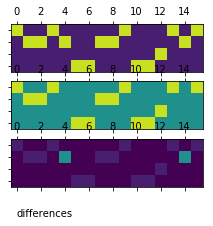

In [99]:
from matplotlib import pyplot as plt
%matplotlib inline


batch = data_source.test.next_batch(1)
batch = np.reshape(batch, [batch.shape[0], batch.shape[1] * batch.shape[2]])
batch = torch.FloatTensor(batch).cpu()
pred = torch.reshape(model(batch[0]), [4, 16]).detach().numpy()
real = torch.reshape(batch[0], [4, 16]).detach().numpy()


plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(real, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(pred, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"reconstructed tensor from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(real - pred, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])


In [67]:
model.fc1.weight.detach()


tensor([[23.5047,  0.3098, -0.3573,  ...,  0.4429, -0.7860,  0.5565],
        [ 0.4131, 22.4170,  0.7066,  ...,  0.3421, -0.1595, -1.4605],
        [-0.2162, -0.7536,  1.2968,  ..., -0.7842, -0.3503, -0.8582],
        ...,
        [-0.4668, -0.3502, -0.3131,  ..., 23.2269,  0.3563,  0.0395],
        [-1.1508, -0.2689, -0.3858,  ...,  0.8956, 24.9147,  0.2631],
        [ 0.2556, -0.1152,  0.9256,  ..., -0.3547,  0.6694, 20.9087]])

In [77]:
foo = torch.reshape(batch[0], [4, 16])#.detach().numpy()
foo

tensor([[0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [80]:
softmax = torch.nn.Softmax(dim=1)
softmax(foo)[:,0:5]

tensor([[0.0407, 0.0407, 0.0407, 0.0407, 0.1105],
        [0.0437, 0.0437, 0.0437, 0.0437, 0.0437],
        [0.0473, 0.1285, 0.1285, 0.0473, 0.0473],
        [0.1188, 0.0437, 0.0437, 0.1188, 0.0437]])

In [85]:
bar = torch.reshape(model(batch[0]), [4, 16])
bar[:,0:5]

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 1.0000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 1.0000, 1.0000, 0.5000, 0.5000],
        [1.0000, 0.5000, 0.5000, 1.0000, 0.5000]], grad_fn=<SliceBackward>)

In [86]:
softmax(bar)[:,0:5]

tensor([[0.0538, 0.0538, 0.0538, 0.0538, 0.0887],
        [0.0538, 0.0538, 0.0538, 0.0538, 0.0538],
        [0.0557, 0.0919, 0.0919, 0.0557, 0.0557],
        [0.0919, 0.0557, 0.0557, 0.0919, 0.0557]], grad_fn=<SliceBackward>)